# Oral Cancer Classification (Binary Classification)
![](https://cdn.prod.website-files.com/67f79caf6539c03c1cc4c273/67f7a001276f81aed5c0b3a5_666b106c0cfbd1b1d23da4c1_unlocking-the-mysteries-of-mouth-cancer-symptoms-and-causes3.jpeg)

### About :

Oral cancer, also known as oral cavity cancer, tongue cancer, or mouth cancer, is a cancer of the lining of the lips, mouth, or upper throat. In the mouth, it most commonly starts as a painless red or white patch that thickens, gets ulcerated, and continues to grow. When on the lips, it commonly looks like a persistent crusting ulcer that does not heal and slowly grows. Other symptoms may include difficult or painful swallowing, new lumps or bumps in the neck, a swelling in the mouth, or a feeling of numbness in the mouth or lips.

Reference: Wikipedia -> https://en.wikipedia.org/wiki/Oral_cancer


### Proposed work :

In this project, I developed an oral cancer classification model using a pre-trained VGG16 architecture. The VGG16 model, originally trained on ImageNet, was fine-tuned to better adapt to the specific features of the oral cancer dataset. Fine-tuning involved:

Freezing the initial convolutional layers to retain general feature extraction.

Unfreezing and retraining the deeper layers to specialize in detecting oral cancer-specific patterns.

Adding custom fully connected layers on top for improved classification performance.

By applying careful fine-tuning and training strategies, the model achieved 85% accuracy on the validation set, demonstrating strong generalization capability on unseen oral cancer and normal tissue images.

This approach leverages the power of transfer learning while customizing the model to our domain-specific task, resulting in efficient and effective performance for oral cancer detection.

## Import Nesasery Libraries

In [1]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [2]:
train_dir = "/kaggle/input/oral-cancer-data/oral_cancer_data/oral_cancer_dataset/train"
test_dir = "/kaggle/input/oral-cancer-data/oral_cancer_data/oral_cancer_dataset/test"
val_dir = "/kaggle/input/oral-cancer-data/oral_cancer_data/oral_cancer_dataset/val"

## Image Pre-processing

In [3]:
image_size = (224, 224)  # Resize images to 224 x 224 pixels

# Data Augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,          
    rotation_range=20,      
    width_shift_range=0.2,  
    height_shift_range=0.2, 
    shear_range=0.2,        
    zoom_range=0.2,         
    horizontal_flip=True,   
    fill_mode='nearest'     
)

# Rescale pixel values for the validation and test data
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data from directory
train_generator = train_datagen.flow_from_directory(
    train_dir,           
    target_size=image_size,         
    batch_size=32,                  
    class_mode='binary'           
)

# Load validation data from directory
val_generator = val_test_datagen.flow_from_directory(
    val_dir,           
    target_size=image_size,        
    batch_size=32,                  
    class_mode='binary'            
)

# Load test data from directory 
test_generator = val_test_datagen.flow_from_directory(
    test_dir,           
    target_size=image_size,        
    batch_size=32,                  
    class_mode='binary',
    shuffle=False  # Fix to maintain correct order for evaluation
)

# Class labels to ensure proper mapping
print(train_generator.class_indices)

Found 861 images belonging to 2 classes.
Found 184 images belonging to 2 classes.
Found 188 images belonging to 2 classes.
{'normal': 0, 'oral_cancer': 1}


In [4]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get class labels from the generator
class_labels = list(train_generator.class_indices.keys())

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced", 
    classes=np.array([0, 1]),  # Ensure binary classification mapping
    y=train_generator.classes
)

# Convert to dictionary format required for Keras
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Print the computed class weights
print("Computed Class Weights:", class_weights)


Computed Class Weights: {0: 1.1181818181818182, 1: 0.9044117647058824}


## Use VGG16 model

In [5]:
# Load VGG16 model
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_base.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

## Fine Tune the model

In [6]:
# Unfreeze the last 5 layers for fine-tuning
for layer in vgg_base.layers[:-5]:
    layer.trainable = False

In [7]:
# Build the model
vgg16_oral = Sequential([
    vgg_base,
    Flatten(),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [8]:
# Final Model Summary
vgg16_oral.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,937,345 (68.43 MB)

 Trainable params: 10,301,633 (39.30 MB)

 Non-trainable params: 7,635,712 (29.13 MB)

In [9]:
# Compile the model
vgg16_oral.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
checkpoint = ModelCheckpoint("oral_cancer_vgg16.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [11]:
# Train the model
history = vgg16_oral.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stopping, checkpoint, lr_scheduler]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 5/27 ━━━━━━━━━━━━━━━━━━━━ 12s 585ms/step - accuracy: 0.5020 - loss: 1.0486

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5172 - loss: 1.0262
Epoch 1: val_accuracy improved from -inf to 0.55435, saving model to oral_cancer_vgg16.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.5175 - loss: 1.0253 - val_accuracy: 0.5543 - val_loss: 3.2823 - learning_rate: 0.0010
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.5497 - loss: 0.9230
Epoch 2: val_accuracy did not improve from 0.55435
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 547ms/step - accuracy: 0.5500 - loss: 0.9217 - val_accuracy: 0.4511 - val_loss: 1.6848 - learning_rate: 0.0010
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.5360 - loss: 0.9092
Epoch 3: val_accuracy did not improve from 0.55435
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 561ms/step - accuracy: 0.5368 - loss: 0.9091 - val_accuracy: 0.4837 - val_loss: 1.0074 - learning_rate: 0.0010
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.5839 - loss: 0.8402
Epoch 4: val_accuracy improved from 0.55435 to 0.586

## Result Analysis

In [12]:
# Evaluate the model
test_loss, test_acc = vgg16_oral.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8143 - loss: 0.4445
Test Accuracy: 83.51%
Test Loss: 0.3849


In [13]:
# Get model predictions
y_pred_prob = vgg16_oral.predict(test_generator)  # Get raw probabilities
y_pred = (y_pred_prob > 0.5).astype("int")  # Convert probabilities to binary labels

# Get true labels
y_true = test_generator.classes  # Actual labels from the test set

# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['normal', 'oral_cancer']))

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 331ms/step
Classification Report:
               precision    recall  f1-score   support

      normal       0.84      0.77      0.81        84
 oral_cancer       0.83      0.88      0.86       104

    accuracy                           0.84       188
   macro avg       0.84      0.83      0.83       188
weighted avg       0.84      0.84      0.83       188



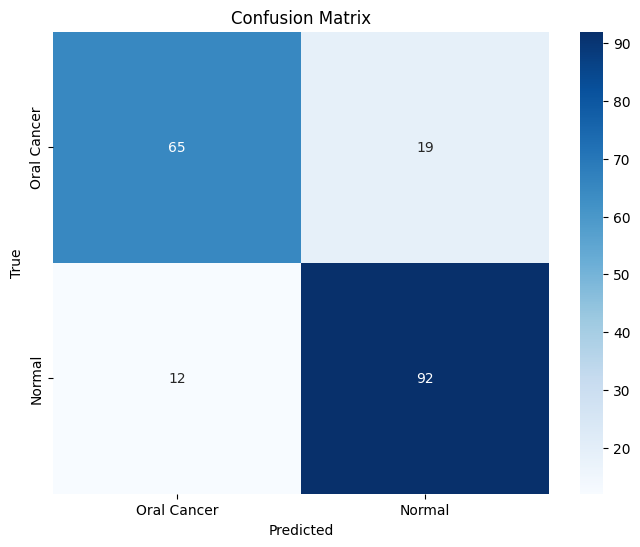

In [14]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class names
class_names = ['Oral Cancer', 'Normal']

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

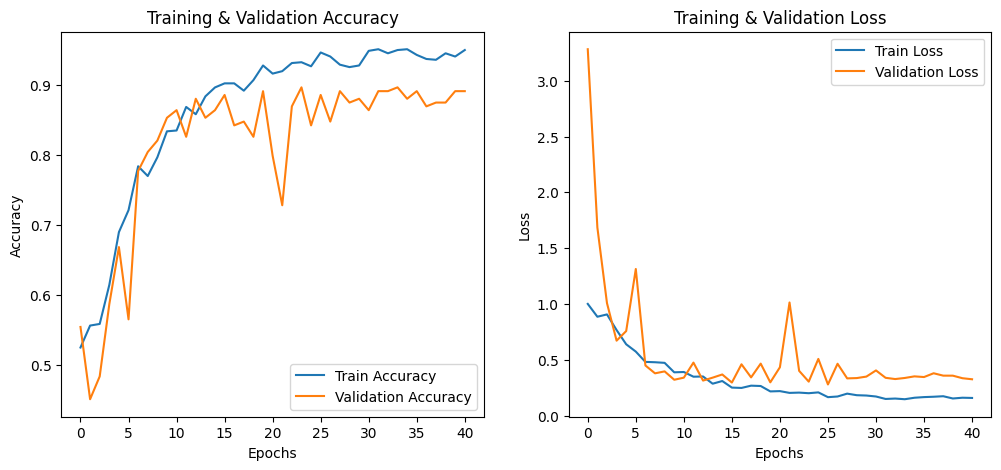

In [15]:
# Plot training & validation accuracy/loss
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()

## Testing on new Image

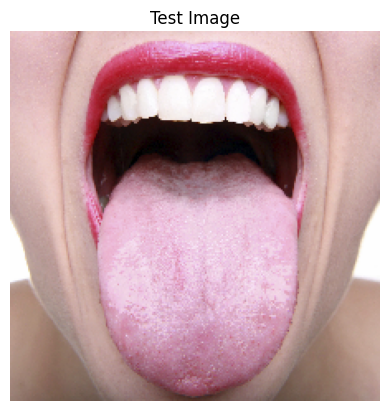

In [16]:
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image

# Path to your test image
image_path = "/kaggle/input/oral-test-image/Oral_dataset/normal_1.jpg"  # Change this to your image path

# Load the image
img = image.load_img(image_path, target_size=(224, 224))  # Resize to 224x224
img_array = image.img_to_array(img)  # Convert to array
img_array = img_array / 255.0  # Normalize (same as training)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Show the image
import matplotlib.pyplot as plt
plt.imshow(img)
plt.axis("off")
plt.title("Test Image")
plt.show()

In [17]:
from tensorflow.keras.models import load_model

# Load the trained model
model_path = "/kaggle/input/oral_cancer_model/keras/default/1/oral_cancer_vgg16.keras" 
vgg16_oral = load_model(model_path)
prediction = vgg16_oral.predict(img_array)

confidence = prediction[0][0] * 100 
if prediction[0][0] > 0.5:
    print(f"Oral Cancer Detected with {confidence:.2f}% confidence")
else:
    print(f"Normal with {(100 - confidence):.2f}% confidence")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Normal with 99.20% confidence
